1) Work out the Neyman-Pearson detection statistic for detecting a rectangular box located at position 555, with hight 1, size 100 in white gaussian noise (np.random.normal(0,1,10**6))
a) Write the statistical model for the two competing hypothesis (H0, H1)
b) If a false detection costs 10^4 dollars, but a true detection gains you a dollar, what would be the detection bar?
c) Suppose that the hight of the rectangular box is unknown, what would you do? Is the test optimal ?
d) Suppose that the noise was complex (as in complex numbers), and that the boxed signal had a uniform "hight" that is a complex number of unknown magnitude and phase. What would you do? is the test optimal?
e) Suppose that the position of the box is unknown. How would you detect it then?
How would you compute the detection statistic at all positions at once using FFT?
What would be the detection bar in this situation, for the same financial conditions as in (Q1 b)? Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect? 
f) What is the amplitude of the box such that if we "inject" a signal with this amplitude, the detection probability is 50% [what about 10%, 99%, 99.99%]
g) What would you do if the size of the box is unknown, and can take any width between 2 bins and 500 bins? Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect? 

2) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,10**6) convolved with a normalized triangular shape of width 500 [normalized such that np.linalg.norm(triangle)=1].
a) Write a statistical model for the null (H0) and the alternative hypothesis (H1) in real space what is the Neyman-Pearson detection statistic you would compute? [use matrix notation]
b) Write a statistical model for the null (H0) and the alternative hypothesis (H1)  in Fourier space. what is the Neyman-Pearson detection statistic you would compute? Is it the same statistic? Simulate a signal and compute the score in several positions, both in real space and Fourier space, make sure you get the same number up to machine precision.
c) Are you more sensitive with this noise source, or in Q1? What is the amplitude of the box such that if we "inject" a signal with this amplitude, the detection probability is 50% [what about 10%, 99%, 99.99%]?
(d) about the 50% detection amplitude as a function of the Triangle's width. Can you compute it analytically? (good approximation is OK) 

3) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,10**6) convolved with a normalized filter of width 500 and unknown shape [normalized such that np.linalg.norm(filter)=1].
a) Is it possible to obtain a good estimator of the filter? [Read about the Welch method AFTER trying to solve it yourself]
b) What is the impact of using the best-estimate filter in the detection statistic computed in (2) ? Is this hampering detection at all?
c) Suppose instead of 10**6 samples, you have only 10**4 samples, how does this impact the precision of estimating the filter?  Is this hampering detection at all?

4) Suppose you have the same situation as in (2), but after generating the noise, Gargamel chooses at random 10**3 samples and zeroizes them.
a) Compute the statistic from (2) in this situation, and plot their histogram. Is that the same histogram as in (2)? Would this interfere with detection?
b) Write the time-domain statistic relevant for detecting a signal at a particular place, taking the missing data into account.

1) Work out the Neyman-Pearson detection statistic for detecting a rectangular box located at position 555, with height 1, size 100 in white gaussian noise (np.random.normal(0,1,10**6))

********
a) $\textbf{Write the statistical model for the two competing hypothesis (H0, H1)}$
********

we have a time series of $ N = 10^6 $ data points $ x_n, n = 0, 1, ..., N-1 $ 

the null hypothesis is that the data is white gaussian noise (WGN): $ w_n \sim N(0,1) $

the alternative hypothesis is that, in addition to WGN, the data contains a rectangular pulse of height $A$ and length $\tau$ starting at time $n_s$ (signal): $ s_n = A (\Theta[\tau - 1 + n_s - n] - \Theta[n_s - n]) \equiv A \hat{s}_n(\tau, n_s) $

we first write these hypotheses as

$ H_0: x_n = w_n $

$ H_1(A, \tau, n_s): x_n = w_n + A \hat{s}_n(\tau, n_s) $

with likelihoods $ L[H|x] = P[x|H] = P[H|x] \frac{P[x]}{P[H]} $

and posterior probabilities $ P[H|x] = \frac{P[H]}{P[x]} $

since we know the noise distribution, we can compute

$ P[x|H_0] = P[w_n = x_n] = \prod_{n=0}^{N-1} \frac{e^{-\frac{x_n^2}{2}}}{\sqrt{2 \pi}} = (2 \pi)^{-\frac{N}{2}} e^{-\sum_{n=0}^{N-1} \frac{x_n^2}{2}} $

$ P[x|H_1(A, \tau, n_s)] = P[w_n = x_n - s_n] = \prod_{n=0}^{N-1} \frac{e^{-\frac{(x_n - s_n)^2}{2}}}{\sqrt{2 \pi}} = (2 \pi)^{-\frac{N}{2}} e^{-\sum_{n=0}^{N-1} \frac{(x_n - s_n)^2}{2}} $

and this gives us the likelihood ratio

$ \Lambda(A, \tau, n_s; x) \equiv \frac{P[x|H_1(A, \tau, n_s)]}{P[x|H_0]} = e^{-\frac{1}{2} \sum_{n=0}^{N-1} ((x_n - s_n)^2 - x_n^2)} = e^{\sum_{n=0}^{N-1} (x_n s_n - \frac{s_n^2}{2})} = e^{-\frac{\tau A^2}{2}} e^{A \sum_{n=0}^{N-1} x_n \hat{s}_n(\tau, n_s)} $

then we reject $H_0$ in favor of $H_1$ when

$ \Lambda(A, \tau, n_s; x) > \eta_{\Lambda} $

where the threshold (detection bar) $\eta_{\Lambda}$ is set by the requirement that

$ P[\Lambda(A, \tau, n_s; x) > \eta_{\Lambda} | H_0] = P[\Lambda(A, \tau, n_s; x_n = w_n) > \eta_{\Lambda}] = \alpha $

for our desired significance level (false detection rate) $\alpha$

the neyman-pearson lemma states that this test has the greatest power, $P[\Lambda(A, \tau, n_s; x) > \eta_{\Lambda} | H_1]$, of all statistical tests at level $\alpha$ because we are using the likelihood ratio to test a simple hypothesis (fully specified model parameters)

further, the lemma states that any monotonic function of the likelihood ratio gives a test statistic with equivalently optimal power at level $\alpha$, so we instead consider

$ \lambda(\tau, n_s; x) \equiv \frac{1}{A}(\ln \Lambda + \frac{\tau A^2}{2}) = \sum_{n=0}^{N-1} x_n \hat{s}_n(\tau, n_s) $

and we reject $H_0$ in favor of $H_1$ when

$ \lambda(\tau, n_s; x) > \eta_{\lambda}(\alpha) $

it is now straightforward to set the threshold $\eta_{\lambda}(\alpha)$ according to

$ P[\lambda(\tau, n_s; x) > \eta_{\lambda}(\alpha) | H_0] = \alpha $

because we can easily compute our test statistic under $H_0$,

$ \lambda(\tau, n_s; x_n = w_n) = \sum_{n=0}^{N - 1} w_n \hat{s}_n(\tau, n_s) = \sum_{n=n_s}^{n_s + \tau - 1} w_n $

and since $w_n$ are $i.i.d.$ standard gaussian RVs, the sum of $\tau$ such variables is also gaussian with mean zero and variance $\tau$, so

$ \frac{1}{\sqrt{\tau}} \lambda(\tau, n_s; x_n = w_n) = \frac{1}{\sqrt{\tau}} \sum_{n=n_s}^{n_s + \tau - 1} w_n \sim N(0,1) \implies $

$ P[\frac{\lambda(\tau, n_s; x)}{\sqrt{\tau}} > \frac{\eta_{\lambda}}{\sqrt{\tau}} | H_0] = 1 - \Phi(\frac{\eta_{\lambda}}{\sqrt{\tau}}) $

where $\Phi(z)$ is the standard gaussian CDF, defined in terms of the error function under mathematica conventions as

$\Phi(z) = \frac{1}{2} (1 + Erf(\frac{z}{\sqrt{2}}))$

thus we can find the threshold $\eta(\alpha)$ using our desired false alarm rate

$ \alpha = 1 - \Phi(\frac{\eta_{\lambda}}{\sqrt{\tau}}) = \frac{1}{2} (1 - Erf(\frac{\eta_{\lambda}}{\sqrt{2 \tau}})) \implies $

$ \frac{\eta_{\lambda}(\alpha)}{\sqrt{\tau}} = \sqrt{2} InverseErf(1 - 2 \alpha) $


********
b) $\textbf{If a false detection costs 10^4 dollars,}$

$\textbf{but a true detection gains you a dollar,}$

$\textbf{what would be the detection bar?}$
********

for cost $C_{FD}$ of false detection and benefit $B_{TD}$ of true detection, we set our false detection rate $ \alpha = \frac{B_{TD}}{C_{FD}} $

here we have $ \alpha = \frac{1}{10^4} \implies $

$ \frac{\eta_{\lambda}(\alpha)}{\sqrt{\tau}} = \sqrt{2} InverseErf(1 - 2*10^{-4}) = 3.71902 $

********
c) $\textbf{Suppose that the height of the rectangular box is unknown,}$

$\textbf{what would you do? Is the test optimal ?}$
********

for an unknown height A, we use the same test statistic $\lambda(\tau, n_s; x)$ from above (which does not depend on A)

it is still an optimal test because the karl-rubin theorem allows you to extend the neyman-pearson lemma from simple hypotheses to composite hypotheses in one unknown parameter (e.g., $ H_1: A > 0 $, as opposed to the simple hypothesis $ H_1: A = a $), under the conditions
(1) the likelihood ratio is monotonic non-decreasing in the data and 
(2) you use a sufficient test statistic which is a monotonic function of the likelihood ratio and independent of the unknown parameter

********
d) $\textbf{Suppose that the noise was complex (as in complex numbers),}$

$\textbf{and that the boxed signal had a uniform "height"} $

$\textbf{that is a complex number of unknown magnitude and phase.}$ 

$\textbf{What would you do? is the test optimal?}$
********

in this case, we have 2 components of data, and under both hypotheses the WGN and supposed "rectangular" signal of unknown complex "height" have components that are independent of each other, so we effectively have 2 independent opportunities to perform the same test (one on each component of the complex data, whether taken as $(Re[x],Im[x])$ or any other basis of the complex plane)

then we can use the same test described above, once for each component, and claim detection if either component's test statistic is above the threshold

however, since you would expect a false positive after $N$ independent tests each at false positive rate $\frac{1}{N}$, we should use false positive rate of approximately $\frac{\alpha}{2}$ for each test in order to preserve the overall rate of $\alpha$ after 2 tests

another way to see this is to recognize that this is the same problem as if we were to have $2n$ samples of a single data component, and we try to detect the signal (of known size $l$ but unknown height $h$) by testing $H0$ against $H1[position]$ at positions $p$ and $n+p$

more generally, if we have a null hypothesis consisting of a pair of independent parameters $(c_1,c_2)$ being equal to zero, and we consider it a detection if either one has a large enough test statistic, then tests with false positive rates $\alpha_1$ and $\alpha_2$ combine for an overall false positive rate of $ \alpha = 1 - (1-\alpha_1)(1-\alpha_2) = \alpha_1 + \alpha_2 - \alpha_1 \alpha_2 $

if we let $\alpha_1 = \alpha_2 = \alpha'$ then $\alpha = \alpha' (2 - \alpha')$ and we can solve for $\alpha' = 1 - \sqrt{1 - \alpha}$

this test is optimal in the sense that we are taking the largest possible $\alpha'$ given the desired overall $\alpha$, and we know that each of the two tests is the most powerful test of its respective component at level $\alpha'$, but the Neyman-Pearson lemma and Karlin-Rubin theorem don't guarantee that the overall test is uniformly most powerful for the two-parameter family of tests -- and in fact, it is ***NOT AN OPTIMAL TEST***

now we have complex WGN $ w_n \sim CN(0,2) \implies \Re(w_n), \Im(w_n) \sim N(0, 1)$

and we search for the complex signal $ s_n = A e^{i \phi} \hat{s}_n(\tau, n_s) $

using the hypotheses

$ H_0: x_n = w_n $

$ H_1(A, \phi, \tau, n_s): x_n = w_n + A e^{i \phi} \hat{s}_n(\tau, n_s) $

this gives us likelihood functions from the PDF of a circularly symmetric complex gaussian (variance = 2 from unit variance of i.i.d. real and imaginary parts)

$ P[x_n | H_0] = P[w_n = x_n] = \prod_n \frac{e^{-\frac{|x_n|^2}{2}}}{2 \pi} $

$ P[x_n | H_1(A, \phi, \tau, n_s)] = P[w_n = x_n - s_n] = \prod_n \frac{e^{-\frac{|x_n - s_n(A, \phi, \tau, n_s)|^2)}{2}}}{2 \pi} $

$ \implies $

$ \Lambda(A, \phi, \tau, n_s; x) = \frac{P[x_n | H_1(A, \phi, \tau, n_s)]}{P[x_n | H_0]} = e^{\sum_n \frac{|x_n|^2 - |x_n - s_n|^2}{2}} = e^{\sum_n (\Re(s_n^{*} x_n) - \frac{|s_n|^2}{2})} =  e^{-\frac{\tau A^2}{2}} e^{A \Re(e^{-i \phi} \sum_n x_n \hat{s}_n)} $

now define the complex statistic $ z(\tau, n_s; x) \equiv \sum_n x_n \hat{s}_n(\tau, n_s) = \sum_{n = n_s}^{n_s + \tau - 1} x_n $

which gives us $ \Lambda(A, \phi, \tau, n_s; x) = e^{-\frac{\tau A^2}{2}} e^{A \Re(e^{-i \phi} z(\tau, n_s; x))} = e^{-\frac{\tau A^2}{2}} e^{A |z| cos(arg(z) - \phi)} $

since the noise is circularly symmetric, it treats all pulse phases equally, so we marginalize over the phase $\phi$ (using a uniform distribution from $0$ to $2 \pi$ as its prior) to get 

$ \Lambda(A, \tau, n_s; x) = e^{-\frac{\tau A^2}{2}} \int_0^{2 \pi} \frac{d\phi}{2 \pi} e^{A |z| cos(arg(z) - \phi)} = e^{-\frac{\tau A^2}{2}} I_0(A |z(\tau, n_s; x)|) $

where $ I_0(y) = \sum_{k = 0}^{\infty} \frac{(\frac{y^2}{4})^k}{(k!)^2} $ is the $0^{th}$-order modified bessel function of the $1^{st}$ kind

noting that $e^{A^2 |z|^2}$ is an upper envelope of $I_0(A |z|)$, we see $\frac{e^{A^2 |z|^2}}{I_0(A |z|)}$ is monotonic non-decreasing in $|z| > 0$, and since the likelihood ratio is again monotonic non-decreasing in the data we can define

$ \lambda(\tau, n_s; x) \equiv \frac{1}{A^2}(\ln(\frac{e^{A^2 |z|^2}}{I_0(A |z|)} \Lambda(A, \tau, n_s; x)) + \frac{\tau A^2}{2}) = |z(\tau, n_s; x)|^2 $

to be our test statistic that is optimal according to neyman-pearson and karl-rubin

that is, our test rejects $H_0$ in favor of $H_1$ when $ \lambda(\tau, n_s; x) > \eta_{\lambda} $, and choosing $\eta_{\lambda}$ such that $ P[\lambda(\tau, n_s; x) > \eta_{\lambda}(\alpha) | H_0] = \alpha $ gives us the most powerful test at significance level $\alpha$ (following the neyman-pearson lemma and karl-rubin theorem)

finally, it is straightforward to determine $\eta_{\lambda}(\alpha)$ because we have

$ \lambda(\tau, n_s; x) = |z(\tau, n_s; x)|^2 = |\sum_n x_n \hat{s}_n(\tau, n_s)|^2 $

$ \implies \frac{1}{\tau} \lambda(\tau, n_s; x) = \frac{|z|^2}{\tau} = (\frac{\Re(z)}{\sqrt{\tau}})^2 + (\frac{\Im(z)}{\sqrt{\tau}})^2 $

then defining $ z_0(\tau, n_s) \equiv z(\tau, n_s; x_n = w_n) $ to be the complex statistic $z(\tau, n_s; x)$ under $H_0$ we have 

$ z_0(\tau, n_s) = \sum_{n = n_s}^{n_s + \tau - 1} w_n \sim CN(0,2 \tau) \implies \Re(z_0), \Im(z_0) \sim N(0, \tau) $

$ \implies \frac{\Re(z_0)}{\sqrt{\tau}}, \frac{\Im(z_0)}{\sqrt{\tau}} \sim N(0, 1) $

and therefore under the null hypothesis $H_0$ we have

$ \frac{1}{\tau} \lambda(\tau, n_s; x_n = w_n) = \frac{|z_0|^2}{\tau} = (\frac{\Re(z_0)}{\sqrt{\tau}})^2 + (\frac{\Im(z_0)}{\sqrt{\tau}})^2 \sim \chi^2(2) $

where $\chi^2(k)$ is the chi-squared distribution with $k$ degrees of freedom, obtained from summing the squares of $k$ standard gaussian RVs, which has a particularly simple CDF for $k = 2$:

$ F_{\chi^2(2)}(y) = 1 - e^{-\frac{y}{2}} \implies F_{\chi^2(2)}^{-1}(p) = -2 \ln(1 - p) $

thus we get

$ P[\frac{\lambda(\tau, n_s; x)}{\tau} > \frac{\eta_{\lambda}(\alpha)}{\tau} | H_0] = P[\chi^2(2) > \frac{\eta_{\lambda}(\alpha)}{\tau}] = 1 - F_{\chi^2(2)}(\frac{\eta_{\lambda}(\alpha)}{\tau}) = \alpha \implies $

$ \frac{\eta_{\lambda}(\alpha)}{\tau} = F_{\chi^2(2)}^{-1}(1 - \alpha) = -2 \ln(\alpha) $

so

$ \frac{\eta_{\lambda}(\alpha = 10^{-4})}{\tau} = 8 \ln(10) = 18.4207 $


********
e) $\textbf{Suppose that the position of the box is unknown. How would you detect it then?}$

$\textbf{How would you compute the detection statistic at all positions at once using FFT?}$

$\textbf{What would be the detection bar in this situation, for the same financial conditions as in (Q1 b)?}$

$\textbf{Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect? }$
********

similar to the phase of the pulse, the noise treats all pulse starting times $n_s$ equally and the prior distribution can be taken to be uniform over all possible start times (which in the context of $H_1$ means that $ n_s = 0, 1, ..., N-1 $ all have probability $\frac{1}{N}$), so we could marginalize the likelihood ratio over $n_s$ to get

$ \Lambda(A, \tau; x) = e^{-\frac{\tau A^2}{2}} \sum_{n_s = 0}^{N - 1} \frac{I_0(A |z(\tau, n_s; x)|)}{N} $

however, the structure of this sum does not admit an analytic procedure for obtaining a test statistic that is independent of the pulse amplitude $A$, so if we want to keep our hypothesis test agnostic with respect to $A$ we must adopt another approach

the standard approach to circumventing the marginalization of the likelihood ratio is to maximize the likelihood ratio over the variable to be marginalized, and since the same $n_s$ that maximizes $\Lambda(A, \tau, n_s; x)$ will maximize a monotonic function of this unmarginalized likelihood ratio, we can simply use

$ \lambda(\tau; x) \equiv max_{n_s} \lambda(\tau, n_s; x) = max_{n_s} |z(\tau, n_s; x)|^2 $

as our test statistic, and our new test rejects $H_0$ in favor of $H_1$ when $ \lambda(\tau; x) > \eta_{\lambda} $, with $\eta_{\lambda}(\alpha)$ such that $ P[\lambda(\tau; x) > \eta_{\lambda}(\alpha) | H_0] = \alpha $

this raises two practical computation questions, because we have to compute $z(\tau, n_s; x)$ for every value of $n_s$ to get $ \lambda(\tau; x) = max_{n_s} |z|^2 $, and we have to find the distribution of $\lambda(\tau; x)$ under the null hypothesis $H_0$ to get $\eta_{\lambda}(\alpha)$

the first question can be addressed by noting that 

$ z(\tau, n_s; x) = \sum_n x_n \hat{s}_n(\tau, n_s) = \sum_n x_n \hat{s}_{n_s - n}(\tau) $

is in fact the discrete convolution of the data $x_n$ with the shifted and reversed unit pulse $\hat{s}_{(n_s - n) \rightarrow n}(\tau) $ whose $\textit{leading}$ edge is now at $n = 0$

since the fourier transform of a convolution is the product of the individual fourier transforms, we can write this as 

$ z(\tau, n_s; x) = F^{-1}[F[x_n]_k F[\hat{s}_{(n_s - n) \rightarrow n}(\tau)]_k]_{n_s} $

where the discrete fourier transform $F[y_n]_k$ and its inverse $F^{-1}[\tilde{y}_k]_n$ can be computed efficiently using an fft algorithm

the only issue is that we need to decide how to extend our domain outside $ 0 \leq n < N $ for the edge cases where $ -\tau \leq n_s < 0 $ or $ N - \tau \leq n_s < N $, which is immediately obvious from the fourier transform description because the only nonzero values of $\hat{s}_{(n_s - n) \rightarrow n}(\tau)$ are for $ -\tau \leq n < 0 $

we could deal with this in two ways:
(1) make the index wraps around (periodic summation) so that $f_n \equiv f_{n \, mod \, N}$, or (2) add $\tau$ zeros to each end of the data and use a vector of size $N + 2 \tau$ to represent the templates $\hat{s}_n(\tau, -\tau \leq n_s < N)$ over indices $ -\tau \leq n < N + \tau $

although (2) is the more physical solution, given the artificial nature of the problem we will use method (1), which is more computationally convenient

thus, we have an efficient way to compute $z(\tau, n_s; x)$ for all $n_s$, and now we address the question of finding the distribution of our test statistic under the null hypothesis $H_0$,

$ \lambda(\tau; x_n = w_n) = max_{n_s} |z_0(\tau, n_s)|^2 $

so that we can choose $\eta_{\lambda}(\alpha)$ such that $ P[\lambda(\tau; x_n = w_n) > \eta_{\lambda}(\alpha)] = \alpha $

if we had $ \tau = 1 $, then $z_0(\tau, n_s)$ would be independent for different values of $n_s$, and we could think of maximizing over all $N$ values of $n_s$ like doing $N$ independent tests of the same hypothesis

when you do $N$ independent trials of the same test, you expect that events of probability $\frac{1}{N}$ might occur, so if you want an overall false alarm rate $\alpha$ to be preserved, you should set the detection bar such that the false alarm rate for each individual test is $ \alpha LEF(N) \approx \frac{\alpha}{N} $, where the factor $LEF(N)$ accounts for this so-called "look-elsewhere effect"

to find $LEF(N)$ for our case, in which the $N$ tests are highly correlated, we will use monte carlo simulation to empirically build the distribution of $\lambda(\tau; x_n = w_n)$ by storing its values for a large number $N_{mc}$ of WGN data realizations, then we will set the detection bar $\eta_{\lambda}(\alpha)$ to be the boundary of the $(1 - \alpha)$-quantile in our set of $N_{mc}$ sampled values of $\lambda(\tau; x_n = w_n)$

to obtain an acceptable approximation of the $(1 - \alpha)$-quantile, we will take $ N_{mc} = \frac{10}{\alpha} $, and once we have $\eta_{\lambda}(\alpha)$ we can get the false alarm rate $ \alpha' = 1 - F_{\chi^2(2)}(\frac{\eta_{\lambda}(\alpha)}{\tau}) = e^{-\frac{\eta_{\lambda}(\alpha)}{2 \tau}} $ that would be achieved by using this detection bar as the threshold for testing a single value of $n_s$, which gives us

$ LEF(N) = \frac{\alpha'}{\alpha} $

In [42]:
import numpy as np
import numba
import matplotlib.pyplot as plt

@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# monte carlo sampling of tests statistics under null hypothesis
def get_stats(stats, N=1000000, tau=100, alpha=0.0001, nsamples=100000):
    ft_signal = np.fft.fft(np.concatenate([np.zeros(N-tau), np.ones(tau)]))
    stats = np.zeros(nsamples)
    for i in np.arange(nsamples):
        stats[i] = max(abs2(np.fft.ifft(ft_signal * \
                                        np.fft.fft(np.random.normal(0, 1, N) + \
                                                   1j*np.random.normal(0, 1, N)))))
    return stats

# plot histogram of monte carlo samples 
def mc_hist(stats, N=1000000, tau=100, alpha=0.0001, nsamples=100000):
    plt.hist(stats, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.xlabel('max|z_0|^2')
    plt.ylabel('count')
    plt.title(str(nsamples) + ' MC samples with N=' + str(N) + \
              ', tau=' + str(tau) + ', alpha=' + str(alpha))
    plt.show()
    return

# get monte carlo samples of test statistics from file and analyze
def get_stats_file(filename, N=1000000, tau=100, alpha=0.0001):
    stats = np.genfromtxt(filename, delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    alpha_prime = np.exp(-bar / float(2*tau))
    lef_N = alpha_prime / alpha
    Nmc = np.size(stats)
    print(str(Nmc), ' samples of N=', str(N), ', tau=', str(tau), ', alpha=', \
          str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bar, alpha_prime, lef_N])
    mc_hist(stats, N=N, tau=tau, alpha=alpha, nsamples=Nmc)
    return stats

N = 10**6
tau = 100
alpha = 10**(-4)
nsamples = 1000#int(10/alpha)
stats_filename = 'h0stats.csv'

for N= 1000000 , tau= 100 , alpha= 0.0001 
get [bar, alpha_prime, lef_N] = 
 [3746.4233708712, 7.323944013933129e-09, 7.323944013933128e-05]


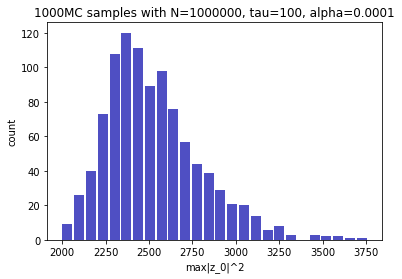

In [37]:
# get stats
stats = get_stats(stats, N=N, tau=tau, alpha=alpha, nsamples=nsamples)
np.savetxt(stats_filename, stats, delimiter=',') # in case we want to revisit
bar = np.quantile(stats, 1 - alpha)
alpha_prime = np.exp(-bar / float(2*tau))
lef_N = alpha_prime / alpha
print(str(nsamples), ' samples of N=', str(N), ', tau=', str(tau), ', alpha=', \
      str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bar, alpha_prime, lef_N])
mc_hist(stats, N=N, tau=tau, alpha=alpha, nsamples=nsamples)

100000  samples of N= 1000000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [4297.731706898745, 4.651512313561326e-10, 4.651512313561326e-06]


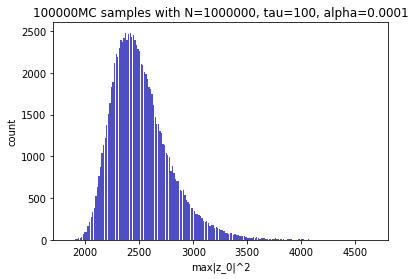

In [40]:
# or if we already wrote stats
s10e6t100 = get_stats_file('max10e6t100_stats.csv', N=1000000, tau=100, alpha=alpha)

100000  samples of N= 500000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [4323.503572272984, 4.089133414768783e-10, 4.089133414768783e-06]


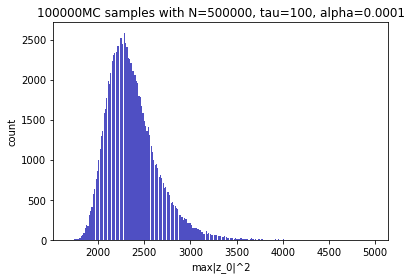

In [41]:
s5x10e5t100 = get_stats_file('max5x10e5t100_stats.csv', N=500000, tau=100, alpha=alpha)

100000  samples of N= 100000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [3781.8736730662163, 6.134309197725981e-09, 6.13430919772598e-05]


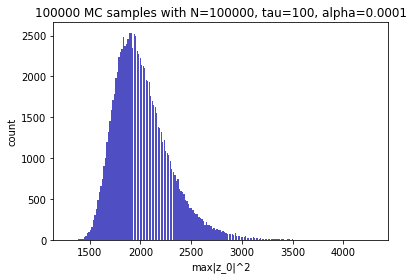

In [43]:
s10e5t100 = get_stats_file('max10e5t100_stats.csv', N=100000, tau=100, alpha=alpha)

100000  samples of N= 50000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [3695.9205779963218, 9.427801654793972e-09, 9.427801654793972e-05]


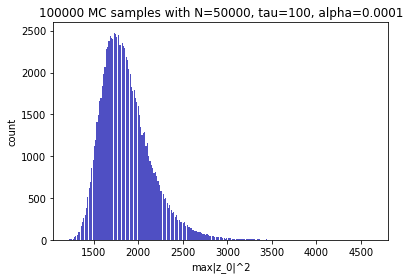

In [44]:
s5x10e4t100 = get_stats_file('max5x10e4t100_stats.csv', N=50000, tau=100, alpha=alpha)

100000  samples of N= 10000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [3372.0513722632636, 4.7608388544162754e-08, 0.00047608388544162755]


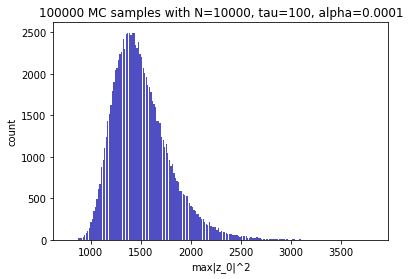

In [45]:
s10e4t100 = get_stats_file('max10e4t100_stats.csv', N=10000, tau=100, alpha=alpha)

********
f) $\textbf{What is the amplitude of the box such that if we "inject" a signal with this amplitude,}$

$\textbf{the detection probability is .5? (what about .1, .99, .9999?)}$
********

the detection probability for an injection is given by

$ P[|z| > \eta | x_n = w_n + s_n] = P[|\tau A e^{i \phi} + z_0| > \eta] = P[(\tau A)^2 + \tau A (e^{-i \phi} z_0 + e^{i \phi} z_0^{*}) > \eta] $

$ = P[(\tau A)^2 + 2 \tau A \Re(e^{-i \phi} z_0) > \eta] = P[\Re(e^{-i \phi} z_0) > \frac{1}{2} (\frac{\eta}{\tau A} - \tau A)] $

where $ z_0 \equiv \sum_{n_s}^{n_{\tau}} w_n \sim CN(0, \tau) $ is the complex test statistic (before taking modulus) under the null hypothesis

as we saw before, this means that $\Re(e^{-i \phi} z_0) \sim N(0, \frac{\tau}{2})$, so we normalize and write our power as

$ \Pi = 1 - \beta = P[\sqrt{\frac{2}{\tau}} \Re(e^{-i \phi} z_0) > \frac{1}{\sqrt{2 \tau}} (\frac{\eta}{\tau A} - \tau A)] = 1 - \Phi(\frac{1}{\sqrt{2 \tau}} (\frac{\eta}{\tau A} - \tau A)) $

where $\Phi$ is the CDF of a standard gaussian

using mathematica's conventions, we have $\Phi(x) = \frac{1}{2} (1 + Erf(\frac{x}{\sqrt{2}}))$, so

$ \Pi(\eta, A, \tau) = \frac{1}{2} (1 - Erf(\frac{1}{2 \sqrt{\tau}} (\frac{\eta}{\tau A} - \tau A))) $

and therefore

$ InverseErf(1 - 2 \Pi(\eta, A, \tau)) = \frac{1}{2 \sqrt{\tau}} (\frac{\eta}{\tau A} - \tau A) \equiv E_{\Pi} \implies $

$ A^2 + \frac{2 E_{\Pi}}{\sqrt{\tau}} A - \frac{\eta}{\tau^2} = 0 \implies $

$ A(\Pi) = \frac{1}{\sqrt{\tau}} (-E_{\Pi} + \sqrt{E_{\Pi}^2 + \frac{\eta}{\tau}}) $

we can plus in the desired power values to get the corresponding $E_{\Pi}$ values:

$ (E_{0.5}, E_{0.1}, E_{0.99}, E_{0.9999}) = (0, 0.906194, -1.64498, -2.62974) $

plugging these into the formula for $A(\Pi)$ gives the corresponding injection amplitudes, and in particular we have

$ A(\Pi = 0.5) = \frac{\sqrt{\eta}}{\tau} $

********
g) $\textbf{What would you do if the size of the box is unknown,}$

$\textbf{and can take any width between 2 bins and 500 bins?}$

$\textbf{Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect?}$ 
********

if the width of the box $\tau$ is unknown, we can compute $z_{n_s}(\tau)$ for each $\tau \in [2, 500]$

then we must answer two questions: what is the new form of the hypothesis testing? and how do we compute the relevant statistics?

to answer the first question, we must recognize the difference between scanning over ranges of $\tau$ and $n_s$: when we scan over $n_s$ we are looking for the same signal at different times, whereas when we scan over $\tau$ we are looking for qualitatively different signals

thus, it doesn't make sense to form the detection problem as a single hypothesis about the existence of some unspecified signal, but rather each value of $\tau$ should have its own hypothesis about the existence of a signal with that shape, which means that a different detection bar should be set for each value of $\tau$

this means that we are no longer looking for a scalar cutoff in a 1d space, but rather a curve $\eta(\tau)$ such that only a fraction $\alpha$ of the points lie above it 

of course, there are many ways to draw this curve because we can treat each value of $\tau$ differently, and since we saw that the power is increasing with $\tau$ for constant $\eta$ and $A$, it makes sense that we would want to trade low-$\tau$ sensitivity for high-$\tau$ sensitivity unless we have some priors about the probability of event occurrence as a joint distribution of $\tau$ and $A$ (or possibly as a function of the total pulse "area" $\tau A$)


********
2) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,10**6) convolved with a normalized triangular shape of width 500 [normalized such that np.linalg.norm(triangle)=1].
********

********
a) Write a statistical model for the null (H0) and the alternative hypothesis (H1) in real space what is the Neyman-Pearson detection statistic you would compute? [use matrix notation]
********

********
b) Write a statistical model for the null (H0) and the alternative hypothesis (H1)  in Fourier space. what is the Neyman-Pearson detection statistic you would compute? Is it the same statistic? Simulate a signal and compute the score in several positions, both in real space and Fourier space, make sure you get the same number up to machine precision.
********

********
c) Are you more sensitive with this noise source, or in Q1? What is the amplitude of the box such that if we "inject" a signal with this amplitude, the detection probability is 50% [what about 10%, 99%, 99.99%]?
********

********
(d) about the 50% detection amplitude as a function of the Triangle's width. Can you compute it analytically? (good approximation is OK) 
********

********
3) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,10**6) convolved with a normalized filter of width 500 and unknown shape [normalized such that np.linalg.norm(filter)=1].
********

********
a) Is it possible to obtain a good estimator of the filter? [Read about the Welch method AFTER trying to solve it yourself]
********

********
b) What is the impact of using the best-estimate filter in the detection statistic computed in (2) ? Is this hampering detection at all?
********

********
c) Suppose instead of 10**6 samples, you have only 10**4 samples, how does this impact the precision of estimating the filter?  Is this hampering detection at all?
********

********
4) Suppose you have the same situation as in (2), but after generating the noise, Gargamel chooses at random 10**3 samples and zeroizes them.
********

********
a) Compute the statistic from (2) in this situation, and plot their histogram. Is that the same histogram as in (2)? Would this interfere with detection?
********

********
b) Write the time-domain statistic relevant for detecting a signal at a particular place, taking the missing data into account.
********